Selected top 500 features using mutual information.
Epoch 1/20 | Train Acc: 5.92% | Val Acc: 7.14%
Epoch 2/20 | Train Acc: 18.95% | Val Acc: 17.46%
Epoch 3/20 | Train Acc: 30.51% | Val Acc: 31.75%
Epoch 4/20 | Train Acc: 46.04% | Val Acc: 37.70%
Epoch 5/20 | Train Acc: 59.76% | Val Acc: 47.22%
Epoch 6/20 | Train Acc: 65.79% | Val Acc: 51.59%
Epoch 7/20 | Train Acc: 71.43% | Val Acc: 45.24%
Epoch 8/20 | Train Acc: 77.29% | Val Acc: 55.95%
Epoch 9/20 | Train Acc: 81.90% | Val Acc: 60.71%
Epoch 10/20 | Train Acc: 83.67% | Val Acc: 55.16%
Epoch 11/20 | Train Acc: 86.85% | Val Acc: 55.56%
Epoch 12/20 | Train Acc: 87.54% | Val Acc: 57.54%
Epoch 13/20 | Train Acc: 91.63% | Val Acc: 56.75%
Epoch 14/20 | Train Acc: 90.10% | Val Acc: 57.94%
Epoch 15/20 | Train Acc: 91.52% | Val Acc: 60.32%
Epoch 16/20 | Train Acc: 92.83% | Val Acc: 60.32%
Epoch 17/20 | Train Acc: 93.80% | Val Acc: 58.33%
Epoch 18/20 | Train Acc: 93.17% | Val Acc: 59.13%
Epoch 19/20 | Train Acc: 93.40% | Val Acc: 56.35%
Epoch 20/

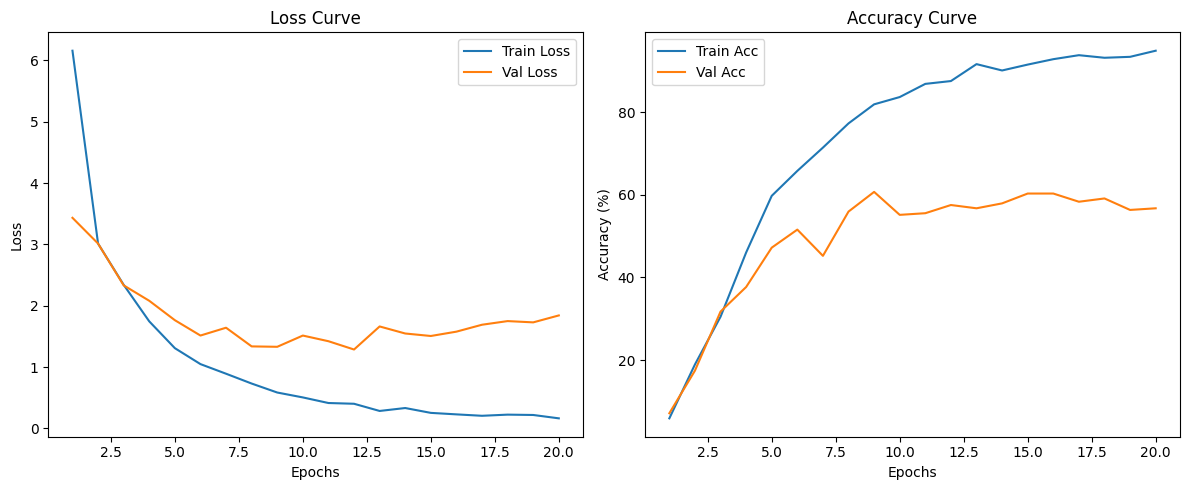

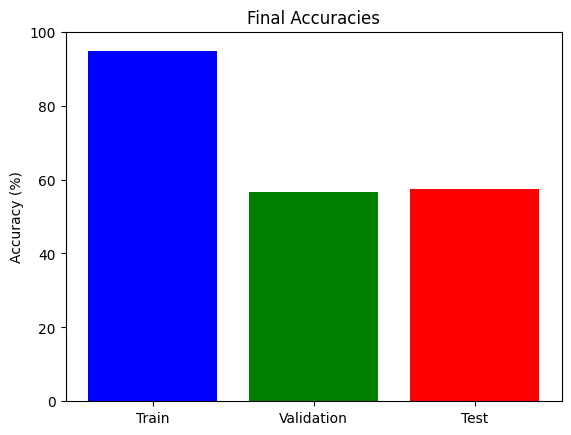

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Load dataset
X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# -------- FEATURE SELECTION FROM SCRATCH (using mutual info) -------- #
def select_top_k_features(X, y, k):
    # Calculate mutual information between each feature and label
    info = mutual_info_classif(X, y, discrete_features=False)
    # Get indices of top k features
    top_k_indices = np.argsort(info)[-k:]
    return X[:, top_k_indices], top_k_indices

k = 500  # <-- Set desired number of features
X_selected, selected_indices = select_top_k_features(X, y, k=k)
print(f"Selected top {k} features using mutual information.")

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets/loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size=k, hidden_size=128, output_size=50):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Track training
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct * 100 / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct * 100 / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_accuracies[-1]:.2f}% | Val Acc: {val_accuracies[-1]:.2f}%")

print("Training Done.")

# Test set evaluation
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == batch_y).sum().item()
        test_total += batch_y.size(0)

test_accuracy = test_correct * 100 / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Plot loss/accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Final bar chart
labels = ["Train", "Validation", "Test"]
accs = [train_accuracies[-1], val_accuracies[-1], test_accuracy]
plt.bar(labels, accs, color=["blue", "green", "red"])
plt.ylim(0, 100)
plt.title("Final Accuracies")
plt.ylabel("Accuracy (%)")
plt.show()



 Selecting top 100 features using mutual information...
 Validation Accuracy: 24.60% | Test Accuracy: 26.49%

 Selecting top 250 features using mutual information...
 Validation Accuracy: 40.87% | Test Accuracy: 44.22%

 Selecting top 500 features using mutual information...
 Validation Accuracy: 60.71% | Test Accuracy: 58.37%

 Selecting top 750 features using mutual information...
 Validation Accuracy: 63.89% | Test Accuracy: 69.52%

 Selecting top 1000 features using mutual information...
 Validation Accuracy: 60.71% | Test Accuracy: 61.75%

 Selecting top 1500 features using mutual information...
 Validation Accuracy: 78.17% | Test Accuracy: 75.30%

 Selecting top 2000 features using mutual information...
 Validation Accuracy: 74.21% | Test Accuracy: 73.51%


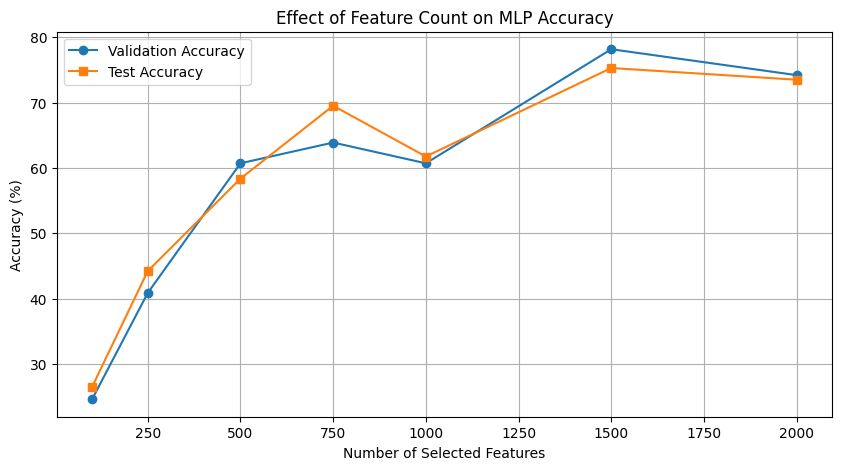

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load data
X = np.load("X_features.npy")
y = np.load("y_labels.npy")

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature sizes to try
feature_counts = [100, 250, 500, 750, 1000, 1500, 2000]
val_acc_list = []
test_acc_list = []

for k in feature_counts:
    print(f"\n Selecting top {k} features using mutual information...")

    # Feature Selection
    mi = mutual_info_classif(X_train, y_train)
    top_k_indices = np.argsort(mi)[-k:]
    X_train_k = X_train[:, top_k_indices]
    X_val_k = X_val[:, top_k_indices]
    X_test_k = X_test[:, top_k_indices]

    # Convert to tensors
    def to_tensor(data, labels):
        return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

    X_train_tensor, y_train_tensor = to_tensor(X_train_k, y_train)
    X_val_tensor, y_val_tensor = to_tensor(X_val_k, y_val)
    X_test_tensor, y_test_tensor = to_tensor(X_test_k, y_test)

    # Loaders
    batch_size = 32
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # MLP model
    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size=128, output_size=50):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            return self.fc3(x)

    model = MLP(input_size=k).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation Accuracy
    model.eval()
    def evaluate(loader):
        correct, total = 0, 0
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)
        return correct * 100 / total

    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)

    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)

    print(f" Validation Accuracy: {val_acc:.2f}% | Test Accuracy: {test_acc:.2f}%")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, val_acc_list, marker='o', label="Validation Accuracy")
plt.plot(feature_counts, test_acc_list, marker='s', label="Test Accuracy")
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy (%)")
plt.title("Effect of Feature Count on MLP Accuracy")
plt.legend()
plt.grid(True)
plt.show()



Best number of features: 2000
Best Validation Accuracy: 78.17%
Corresponding Test Accuracy: 76.89%


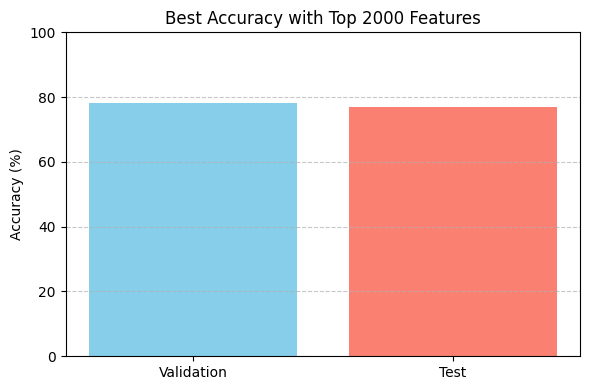

In [ ]:
# Identify the best feature count based on validation accuracy
best_index = np.argmax(val_acc_list)
best_k = feature_counts[best_index]
best_val_acc = val_acc_list[best_index]
best_test_acc = test_acc_list[best_index]

print(f"\nBest number of features: {best_k}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Corresponding Test Accuracy: {best_test_acc:.2f}%")

# Plot best val/test accuracy as bar graph
plt.figure(figsize=(6, 4))
plt.bar(["Validation", "Test"], [best_val_acc, best_test_acc], color=["skyblue", "salmon"])
plt.title(f"Best Accuracy with Top {best_k} Features")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
